In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from preprocessing import unify_series_and_franchise_columns
from preprocessing import (
    WIKIDATA_FILM_ID,
    WIKIDATA_BUDGET,
    WIKIDATA_REVENUE,
    RELEASE_DATE,
    CRITIC_RATING,
    AUDIENCE_RATING,
    BUDGET,
    REVENUE,
    IMDB_RELEASE_DATE,
    IMDB_ID,
    ROTTEN_TOMATOES_ID,
    GROUP_ID,
    GROUP_LABEL,
    N_FILMS_IN_GROUP,
    INDEX_IN_GROUP,
    BUDGET_FROM_IMDB,
    REVENUE_FROM_IMDB,
    ROI,
)

In [81]:
# Includes columns about reviews and audience metrics 
rt_movies_df = pd.read_csv("../data/rotten_tomatoes_movies.csv")

# Includes columns about franchise and series ids
wikidata_movies_df = pd.read_csv("../data/rotten_tomatoes_movies_with_money_2.csv")

# Include columns from IMDB about budget and box office value
imdb_movies_df = pd.read_csv("../data/clean_tmdb.csv")

# Unify series and franchise columns
wikidata_movies_df = unify_series_and_franchise_columns(wikidata_movies_df)

# Add reviews and audience metrics from Rotten Tomatoes
wikidata_movies_df = wikidata_movies_df.merge(rt_movies_df, on=ROTTEN_TOMATOES_ID, how="inner")

# wikidata_movies_df lacks budget and box office value for many movies
print("Missing budget:", wikidata_movies_df[WIKIDATA_BUDGET].isna().sum(), "out of", wikidata_movies_df.shape[0])
print("Missing box_office_value:", wikidata_movies_df[WIKIDATA_REVENUE].isna().sum(), "out of", wikidata_movies_df.shape[0])

# Try to fill in missing budget and box office value from IMDB
wikidata_movies_df = wikidata_movies_df.merge(imdb_movies_df[[BUDGET, REVENUE, IMDB_ID]], on=IMDB_ID, how="left")
# Rename columns to avoid confusion
wikidata_movies_df = wikidata_movies_df.rename(columns={BUDGET: BUDGET_FROM_IMDB, REVENUE: REVENUE_FROM_IMDB})

# Now dataframe has columns:
# - BUDGET (from Wikidata)
# - REVENUE (from Wikidata)
# - BUDGET_FROM_IMDB (from IMDB)
# - REVENUE_FROM_IMDB (from IMDB)

# How many missing budget can we fill from IMDB?
print("Number of missing budgets filled from IMDB:", 
      (wikidata_movies_df[WIKIDATA_BUDGET].isna() & wikidata_movies_df[BUDGET_FROM_IMDB].notna()).sum())

# How many missing box office values can we fill from IMDB?
print("Number of missing box office values filled from IMDB:",
        (wikidata_movies_df[WIKIDATA_REVENUE].isna() & wikidata_movies_df[REVENUE_FROM_IMDB].notna()).sum())

# Unify the budget and box office value columns so we have only one of each
wikidata_movies_df[BUDGET] = wikidata_movies_df[WIKIDATA_BUDGET].fillna(wikidata_movies_df[BUDGET_FROM_IMDB])
wikidata_movies_df[REVENUE] = wikidata_movies_df[WIKIDATA_REVENUE].fillna(wikidata_movies_df[REVENUE_FROM_IMDB])
# Calculate ROI column
wikidata_movies_df[ROI] = wikidata_movies_df[REVENUE] / wikidata_movies_df[BUDGET]

# How many missing budget and box office values remain?
print("Remaining missing budgets:", wikidata_movies_df[BUDGET].isna().sum(), "out of", wikidata_movies_df.shape[0])
print("Remaining missing box office values:", wikidata_movies_df[REVENUE].isna().sum(), "out of", wikidata_movies_df.shape[0])

# Removing rows with missing or zero budget or box office value
rows_to_remove = wikidata_movies_df[BUDGET].isna() | wikidata_movies_df[REVENUE].isna() | (wikidata_movies_df[BUDGET] <= 0) | (wikidata_movies_df[REVENUE] <= 0)
print("Removing", rows_to_remove.sum(), "rows with missing or zero budget or box office value")
wikidata_movies_df = wikidata_movies_df[~rows_to_remove]
print("Number of movies with budget and box office value:", wikidata_movies_df.shape[0])
print("-" * 50)

# Calculating how many movies are in group for each line
wikidata_movies_df[N_FILMS_IN_GROUP] = wikidata_movies_df.groupby([GROUP_ID]).transform('size')

# Keep only movies that are part of a group with more than one movie
valid_number_of_films_in_group = wikidata_movies_df[N_FILMS_IN_GROUP] > 1
invalid_number_of_films_in_group = ~valid_number_of_films_in_group
wikidata_movies_df = wikidata_movies_df[~invalid_number_of_films_in_group]
print("Removing", invalid_number_of_films_in_group.sum(), "rows that are the only movie in their group")
print("Number of movies part of a group with more than one movie:", wikidata_movies_df.shape[0])
print("-" * 50)

# wikidata_movies_df lacks release_date for many movies
print("Missing release_date:", wikidata_movies_df[RELEASE_DATE].isna().sum(), "out of", wikidata_movies_df.shape[0])
# Try to fill in missing release_date from IMDB
wikidata_movies_df = wikidata_movies_df.merge(imdb_movies_df[[IMDB_ID, IMDB_RELEASE_DATE]], on=IMDB_ID, how="left")
print("Number of missing release_date filled from IMDB:", (wikidata_movies_df[RELEASE_DATE].isna() & wikidata_movies_df[IMDB_RELEASE_DATE].notna()).sum())
# Unify the release_date columns so we have only one
wikidata_movies_df[RELEASE_DATE] = wikidata_movies_df[RELEASE_DATE].fillna(wikidata_movies_df[IMDB_RELEASE_DATE])

wikidata_movies_df = wikidata_movies_df.sort_values(by=RELEASE_DATE)
wikidata_movies_df[INDEX_IN_GROUP] = wikidata_movies_df.groupby(GROUP_ID).cumcount()


Missing budget: 603 out of 1277
Missing box_office_value: 584 out of 1277
Number of missing budgets filled from IMDB: 364
Number of missing box office values filled from IMDB: 323
Remaining missing budgets: 239 out of 1277
Remaining missing box office values: 261 out of 1277
Removing 335 rows with missing or zero budget or box office value
Number of movies with budget and box office value: 942
--------------------------------------------------
Removing 152 rows that are the only movie in their group
Number of movies part of a group with more than one movie: 790
--------------------------------------------------
Missing release_date: 7 out of 790
Number of missing release_date filled from IMDB: 7


In [103]:
RES = dict()


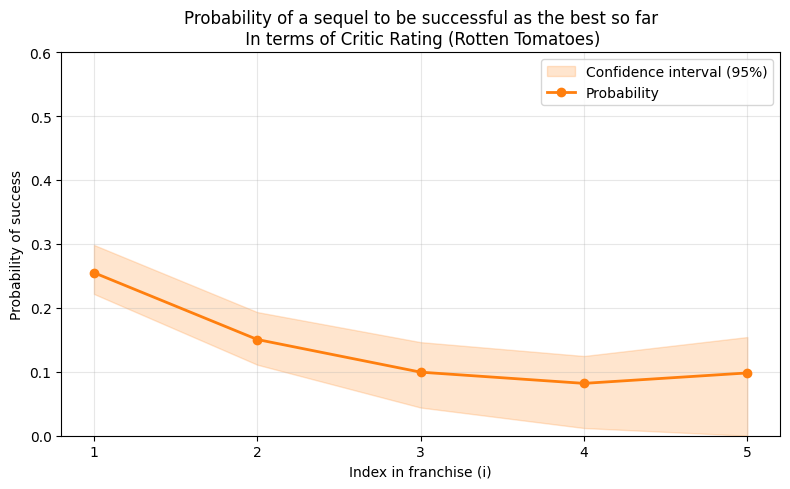

In [108]:
# ROI, AUDIENCE_RATING, CRITIC_RATING
METRIC_COL = AUDIENCE_RATING
MIN_LENGTH_OF_GROUP = 0
MAX_LENGTH_OF_GROUP = 6

TOLERANCE_FOR_SUCCESSFUL = 0 # define "as successful as best so far" as pct_vs_best_so_far >= tol (e.g., -5 for within -5%)
M = 10  # prior strength for Bayesian shrinkage (larger means stronger prior, more shrinkage towards mean)
ALPHA = 0.2

_BEST_METRIC_VALUE_SO_FAR = "best_metric_value_so_far"
_PERCENT_OF_BEST_SO_FAR = "percent_of_best_so_far"
_AS_SUCCESSFUL_AS_BEST_SO_FAR = "as_successful_as_best_so_far"
_PROB_OF_SUCCESS_NAIVE = "prob_of_success_naive"
N_SUCCESSES = "n_successes"
N_MOVIES = "n_movies"
_BAYESIAN_SHRUNKEN_PROB_OF_SUCCESS = "bayesian_shrunken_prob_of_success"
_CI_LOWER = "ci_lower"
_CI_UPPER = "ci_upper"

df = wikidata_movies_df.copy()

# Keep only groups with at least MIN_LENGTH_OF_GROUP and at most MAX_LENGTH_OF_GROUP movies
df = df[(df[N_FILMS_IN_GROUP] >= MIN_LENGTH_OF_GROUP) & (df[N_FILMS_IN_GROUP] <= MAX_LENGTH_OF_GROUP)]
# Assert no missing or inf values in metric column
assert df[METRIC_COL].notna().all() & (np.isfinite(df[METRIC_COL])).all(), "Metric column contains missing or infinite values"

# Drop missing GROUPING_COL values and resort
df = df[df[GROUP_ID].notna()].sort_values(by=[GROUP_ID, RELEASE_DATE])

# For each group at each index calculate the best metric value so far (before current movie)
df[_BEST_METRIC_VALUE_SO_FAR] = df.groupby(GROUP_ID, sort=False)[METRIC_COL].cummax()
df[_BEST_METRIC_VALUE_SO_FAR] = df.groupby(GROUP_ID, sort=False)[_BEST_METRIC_VALUE_SO_FAR].shift(1)

# Calculate % gap vs best-so-far (positive means >= best-so-far)
df[_PERCENT_OF_BEST_SO_FAR] = 100.0 * (df[METRIC_COL] / df[_BEST_METRIC_VALUE_SO_FAR] - 1.0)

# Keep only rows that have a previous best to compare to (i.e., not the first movie in each franchise)
df = df[df[_BEST_METRIC_VALUE_SO_FAR].notna()]

# Calculate indicator of whether current movie is as successful as best-so-far (1 if yes, 0 if no)
df[_AS_SUCCESSFUL_AS_BEST_SO_FAR] = (df[_PERCENT_OF_BEST_SO_FAR] >= TOLERANCE_FOR_SUCCESSFUL).astype(int)

# Aggregate per index: calculate number of successes and total number of movies
agg_df = df.groupby(INDEX_IN_GROUP, as_index=False).agg(
    n_successes = (_AS_SUCCESSFUL_AS_BEST_SO_FAR, 'sum'),
    n_movies = (_AS_SUCCESSFUL_AS_BEST_SO_FAR, 'count')
)

# The statistical model
#
# Define:
# K_i = number of successes at index i (i.e., number of movies at index i that are as successful as the best so far)
# N_i = total number of movies (from all groups) at index i
# P_i = probability that a movie at index i is as successful as the best so far
#
# For each sequel index i (1, 2, 3, ...), we want to estimate the probability that a movie at that index is as successful as the best so far.
# We want to estimate P_i ≈ K_i / N_i
# However, for many indices we have very few movies (small N_i), so the estimate K_i / N_i is very noisy.
# To improve the estimate, we use Bayesian statistics to "shrink" the estimate towards a prior mean.
#
# Lets assume simple model:
#
# K_i | P_i ~ Binomial(N_i, P_i) (given the unknown probability P_i, the number of successes K_i follows a Binomial distribution with parameters N_i and P_i)
# P_i ~ Beta(a, b) (the prior distribution of P_i is itself random, drawn from a Beta distribution)
#
# The mean of the Beta distribution is P_mean = a / (a + b) (This is our prior belief about the probability of success, before seeing any data)
# m = a + b is the "strength" of our prior belief, larger m means the prior is "tight" around the mean
# and smaller m means the prior is "loose" and more uncertain
#
# Now, we ask a different question:
# What is the posterior distribution of P_i given K_i and N_i? (Posterior means "after seeing the data")
# It turns out that a Beta prior + Binomial likelihood = Beta posterior.
# 
# Posterior[P_i | K_i, N_i] ~ Beta(a + K_i, b + N_i - K_i)
# 
# i.e., the posterior distribution of P_i is also a Beta distribution, with updated parameters a + K_i and b + N_i - K_i
# So we can easily estimate the posterior mean of P_i:
#
# E[P_i | K_i, N_i] = (a + K_i) / (a + b + N_i) = (m * P_mean + K_i) / (m + N_i)
# We'll call this the "Bayesian shrinkage estimate" of P_i
#
# This is a weighted average of our prior mean P_mean and the observed success rate K_i / N_i
# If N_i is large, the posterior mean is close to the observed success rate K_i / N_i
# If N_i is small, the posterior mean is close to the prior mean P_mean
#
# How to choose a, b (or equivalently P_mean and m)?
# We can use the overall success rate across all indices as our prior mean P_mean
#
# P_mean = sum(K_i) / sum(N_i)
#
# We can choose m based on how much we want to shrink the estimates towards the prior mean.
# m = 5 means weak prior, m in [10, 50] means moderate prior, m > 100 means strong prior




# Assert that n_successes <= n_movies at each index and n_movies > 0
assert (agg_df[N_SUCCESSES] <= agg_df[N_MOVIES]).all() & (agg_df[N_MOVIES] > 0).all(), "Invalid aggregation results"

K_i = agg_df[N_SUCCESSES]
N_i = agg_df[N_MOVIES]

# Calculate naive estimate of probability of success at each index
agg_df[_PROB_OF_SUCCESS_NAIVE] = K_i / N_i

# Calculate mean success rate across all indices to use as prior mean
P_mean = K_i.sum() / N_i.sum()

# Calculate shrunken estimate of probability of success at each index
agg_df[_BAYESIAN_SHRUNKEN_PROB_OF_SUCCESS] = (K_i + M * P_mean) / (N_i + M)

# Calculate Wilson confidence interval 95% (better for proportions than normal approx)
z = norm.ppf(1 - ALPHA / 2)
P_i = agg_df[_PROB_OF_SUCCESS_NAIVE]
density =  1.0 + (z ** 2) / N_i
center = (P_i + (z ** 2) / (2.0 * N_i)) / density
margin =  (z * np.sqrt((P_i * (1.0 - P_i) + (z ** 2) / (4.0 * N_i)) / N_i)) / density

agg_df[_CI_LOWER] = np.clip(center - margin, 0.0, 1.0)
agg_df[_CI_UPPER] = np.clip(center + margin, 0.0, 1.0)

# Plot

X = agg_df[INDEX_IN_GROUP]
Y_SHRUNK = agg_df[_BAYESIAN_SHRUNKEN_PROB_OF_SUCCESS]
CI_LO = agg_df[_CI_LOWER]
CI_HI = agg_df[_CI_UPPER]

fig, ax = plt.subplots(figsize=(8, 5))

# Plot CI as shaded region
ax.fill_between(X, CI_LO, CI_HI, color="tab:orange", alpha=0.2, label="Confidence interval (95%)")

# Plot Bayesian shrunken estimate as line with markers
ax.plot(X, Y_SHRUNK, marker="o", color="tab:orange", linewidth=2, label="Probability")

# Labels and grid
ax.set_xlabel("Index in franchise (i)")
ax.set_ylabel("Probability of success")
ax.set_ylim(0, 0.6)
ax.set_xticks(np.arange(int(X.min()), int(X.max()) + 1, 1))  # integer ticks
ax.grid(True, alpha=0.3)

# Legend
ax.legend(loc="upper right")
ax.set_title("Probability of a sequel to be successful as the best so far\n In terms of Critic Rating (Rotten Tomatoes)")

plt.tight_layout()
plt.show()


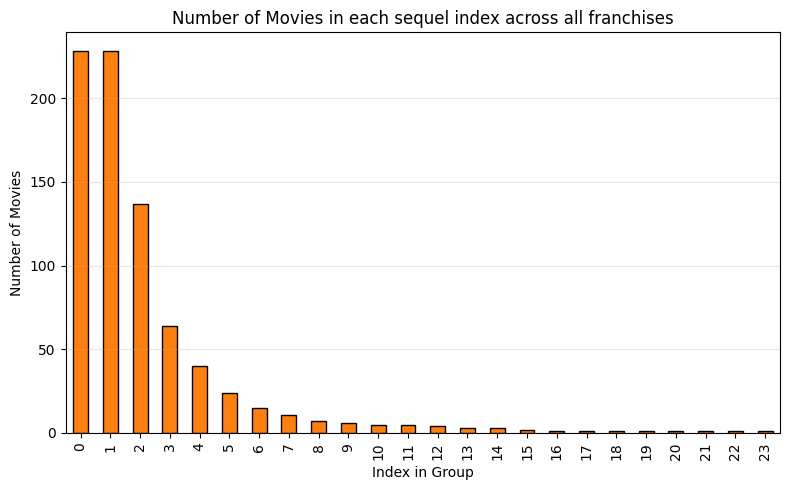

In [91]:
wikidata_movies_df[INDEX_IN_GROUP].value_counts().sort_index().plot(kind='bar', figsize=(8, 5), color='tab:orange', edgecolor='black')
plt.xlabel('Index in Group')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in each sequel index across all franchises')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()